### Load the Libraries and Initialize the GPU

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

import wandb

import numpy as np
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt


from tqdm import tqdm

import plotly.graph_objs as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

### Wand


In [3]:
wandb.login()

wandb.init(project='dissertation',
           name='Test',
           entity='tomchow')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


### Load Data

In [4]:
iv_data = pd.read_csv('./Data/iv_data_nifty.csv')
# data
# data['Market Direction'] = np.where(data['Price'] < data['Price'].shift(-1), 1, 0)
# data.to_csv('./Data/iv_data_nifty.csv')
# data.head(5)

In [5]:
data = iv_data[['Datetime', 'Expiry', 'Price', 'IV_ITM_5', 'IV_ITM_4', 'IV_ITM_3', 'IV_ITM_2', 'IV_ITM_1', 'IV_ATM', 'IV_OTM_1', 'IV_OTM_2', 'IV_OTM_3', 'IV_OTM_4', 'IV_OTM_5']]
data = data.replace(0, np.nan)
print('Null Count',data.isnull().sum())
# labels = iv_data['Market Direction'].values.astype('int')
# print('Null Count Labels',labels.isnull().sum())


# data = iv_data #iv_data[['IV_ATM']]  #data[['Price']]
# print(type(data))   

data = data.interpolate(method='linear')
data.dropna(inplace=True)
dates = data[['Datetime', 'Expiry']]
data = data[['IV_ITM_5', 'IV_ITM_4', 'IV_ITM_3', 'IV_ITM_2', 'IV_ITM_1', 'IV_ATM', 'IV_OTM_1', 'IV_OTM_2', 'IV_OTM_3', 'IV_OTM_4', 'IV_OTM_5']]


print('Null Count',data.isnull().sum())

# print(data.eq(0).sum())
data = data.values.astype('float32')

# print('Data and Label', data.shape, labels.shape)
# print(labels[:5])

Null Count Datetime       0
Expiry         0
Price          0
IV_ITM_5    5333
IV_ITM_4    3116
IV_ITM_3    1398
IV_ITM_2     339
IV_ITM_1      59
IV_ATM        34
IV_OTM_1      69
IV_OTM_2     314
IV_OTM_3    1417
IV_OTM_4    3317
IV_OTM_5    5751
dtype: int64
Null Count IV_ITM_5    0
IV_ITM_4    0
IV_ITM_3    0
IV_ITM_2    0
IV_ITM_1    0
IV_ATM      0
IV_OTM_1    0
IV_OTM_2    0
IV_OTM_3    0
IV_OTM_4    0
IV_OTM_5    0
dtype: int64


/tmp/ipykernel_1022/782826378.py:11: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear')


### Train-Test Split

In [6]:
# train-test split for time series
train_size = int(len(data) * 0.70)
test_size = len(data) - train_size

train_dates = dates[:train_size]
test_dates = dates[train_size:]


# train_X, train_y = data[:train_size], labels[:train_size]
# test_X, test_y = data[train_size:], labels[train_size:]

train_data = data[:train_size]  #, labels[:train_size]
test_data = data[train_size:] #, labels[train_size:]


print(train_data.shape, test_data.shape)

(22596, 11) (9685, 11)


### Scaling

In [7]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1)) # RobustScaler() 
scaler.fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

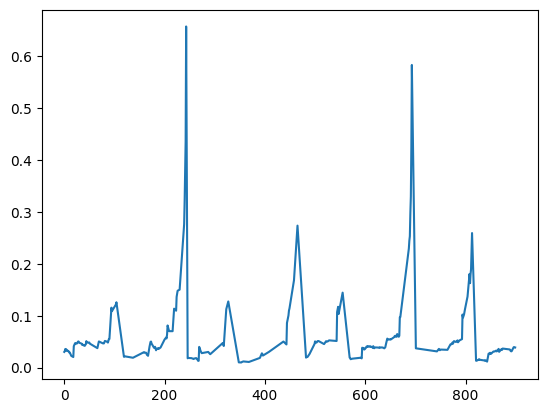

In [8]:
plt.plot(train_data[100:1000,10].reshape(-1))


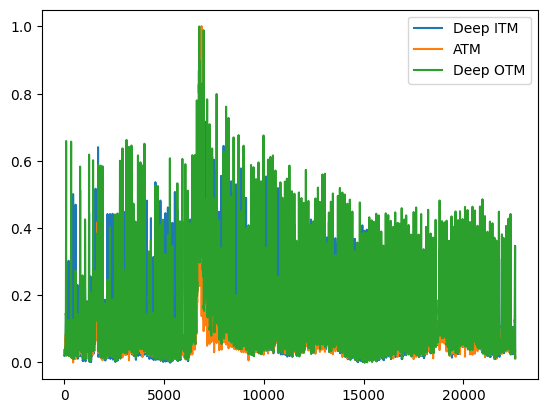

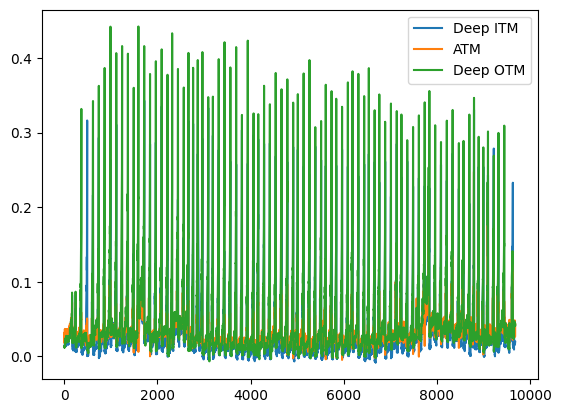

In [9]:
# plt.plot(train_data.reshape(-1))
# plt.plot(test_data.reshape(-1))

plt.plot(train_data[:,0].reshape(-1))
plt.plot(train_data[:,5].reshape(-1))
plt.plot(train_data[:,10].reshape(-1))
plt.legend(['Deep ITM', 'ATM', 'Deep OTM'])
plt.show()

plt.plot(test_data[:,0].reshape(-1))
plt.plot(test_data[:,5].reshape(-1))
plt.plot(test_data[:,10].reshape(-1))
plt.legend(['Deep ITM', 'ATM', 'Deep OTM'])

plt.show()

### Dataset Class

In [10]:
def create_dataset(dataset, n_lookback, n_forecast):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        n_lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-n_lookback): 
        feature = dataset[i:i+n_lookback]
        # target = dataset[i+1:i+n_lookback+1]
        target = dataset[i+n_lookback:i+n_lookback+n_forecast]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)



In [11]:
n_lookback = 30 ## last 30 mins IV

n_forecast = 1

##(window size, time steps, features))
X_train, y_train = create_dataset(train_data, n_lookback=n_lookback, n_forecast=n_forecast)
X_test, y_test = create_dataset(test_data, n_lookback=n_lookback, n_forecast=n_forecast)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

/tmp/ipykernel_1022/3929322628.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X), torch.tensor(y)


torch.Size([22566, 30, 11]) torch.Size([22566, 1, 11])
torch.Size([9655, 30, 11]) torch.Size([9655, 1, 11])


### Simple LSTM Model

In [12]:
# LSTM

# input_dim = 11
hidden_dim = 64
n_features = 11


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.25)
        self.linear = nn.Linear(hidden_dim, n_features) 
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        # print('after LSTM',x.shape)
        x = x[:, -1, :]  # (batch_size, n_lookback, hidden_dim) -> (batch_size, 1, hidden_dim)

        x = self.linear(x) #.view(-1,  n_forecast, input_dim)
        # print('after linear',x.shape)
        # print(x.shape)
        return x

### Trainning

In [13]:
batch_size = 64 ## Higher
n_epochs = 100
lr = 0.0001

 
model = Model()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.MSELoss()

## Dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
# test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)
 
epoch_accuracies = []
epoch_losses = []

train_losses = []
test_losses = []

### Train

100%|██████████| 353/353 [00:06<00:00, 51.82it/s]


Epoch 0 Loss 0.0703


100%|██████████| 353/353 [00:05<00:00, 59.87it/s]


Epoch 1 Loss 0.0434


100%|██████████| 353/353 [00:05<00:00, 59.36it/s]


Epoch 2 Loss 0.0399


100%|██████████| 353/353 [00:05<00:00, 62.49it/s]


Epoch 3 Loss 0.0376


100%|██████████| 353/353 [00:05<00:00, 62.30it/s]


Epoch 4 Loss 0.0357


100%|██████████| 353/353 [00:05<00:00, 62.42it/s]


Epoch 5 Loss 0.0345


100%|██████████| 353/353 [00:06<00:00, 58.19it/s]


Epoch 6 Loss 0.0333


100%|██████████| 353/353 [00:05<00:00, 61.13it/s]


Epoch 7 Loss 0.0325


100%|██████████| 353/353 [00:05<00:00, 59.99it/s]


Epoch 8 Loss 0.0314


100%|██████████| 353/353 [00:06<00:00, 57.37it/s]


Epoch 9 Loss 0.0307


100%|██████████| 353/353 [00:05<00:00, 60.70it/s]


Epoch 10 Loss 0.0303


100%|██████████| 353/353 [00:06<00:00, 50.81it/s]


Epoch 11 Loss 0.0298


100%|██████████| 353/353 [00:06<00:00, 52.95it/s]


Epoch 12 Loss 0.0295


100%|██████████| 353/353 [00:06<00:00, 55.36it/s]


Epoch 13 Loss 0.0288


100%|██████████| 353/353 [00:06<00:00, 55.19it/s]


Epoch 14 Loss 0.0284


100%|██████████| 353/353 [00:06<00:00, 55.53it/s]


Epoch 15 Loss 0.0284


100%|██████████| 353/353 [00:06<00:00, 57.13it/s]


Epoch 16 Loss 0.0281


100%|██████████| 353/353 [00:06<00:00, 57.48it/s]


Epoch 17 Loss 0.0282


100%|██████████| 353/353 [00:06<00:00, 56.50it/s]


Epoch 18 Loss 0.0276


100%|██████████| 353/353 [00:06<00:00, 56.82it/s]


Epoch 19 Loss 0.0273


100%|██████████| 353/353 [00:06<00:00, 54.41it/s]


Epoch 20 Loss 0.0271


100%|██████████| 353/353 [00:06<00:00, 54.51it/s]


Epoch 21 Loss 0.0271


100%|██████████| 353/353 [00:05<00:00, 59.33it/s]


Epoch 22 Loss 0.0266


100%|██████████| 353/353 [00:06<00:00, 58.04it/s]


Epoch 23 Loss 0.0267


100%|██████████| 353/353 [00:06<00:00, 57.93it/s]


Epoch 24 Loss 0.0264


100%|██████████| 353/353 [00:05<00:00, 59.46it/s]


Epoch 25 Loss 0.0263


100%|██████████| 353/353 [00:05<00:00, 58.87it/s]


Epoch 26 Loss 0.0262


100%|██████████| 353/353 [00:06<00:00, 57.25it/s]


Epoch 27 Loss 0.0260


100%|██████████| 353/353 [00:06<00:00, 57.38it/s]


Epoch 28 Loss 0.0260


100%|██████████| 353/353 [00:06<00:00, 55.48it/s]


Epoch 29 Loss 0.0258


100%|██████████| 353/353 [00:06<00:00, 55.62it/s]


Epoch 30 Loss 0.0257


100%|██████████| 353/353 [00:05<00:00, 60.60it/s]


Epoch 31 Loss 0.0258


100%|██████████| 353/353 [00:06<00:00, 58.60it/s]


Epoch 32 Loss 0.0256


100%|██████████| 353/353 [00:06<00:00, 58.14it/s]


Epoch 33 Loss 0.0257


100%|██████████| 353/353 [00:06<00:00, 52.09it/s]


Epoch 34 Loss 0.0251


100%|██████████| 353/353 [00:07<00:00, 44.73it/s]


Epoch 35 Loss 0.0250


100%|██████████| 353/353 [00:06<00:00, 54.08it/s]


Epoch 36 Loss 0.0251


100%|██████████| 353/353 [00:06<00:00, 55.11it/s]


Epoch 37 Loss 0.0251


100%|██████████| 353/353 [00:06<00:00, 55.19it/s]


Epoch 38 Loss 0.0251


100%|██████████| 353/353 [00:06<00:00, 57.15it/s]


Epoch 39 Loss 0.0250


100%|██████████| 353/353 [00:07<00:00, 50.39it/s]


Epoch 40 Loss 0.0249


100%|██████████| 353/353 [00:07<00:00, 50.20it/s]


Epoch 41 Loss 0.0249


100%|██████████| 353/353 [00:07<00:00, 49.67it/s]


Epoch 42 Loss 0.0249


100%|██████████| 353/353 [00:03<00:00, 97.96it/s] 


Epoch 43 Loss 0.0248


100%|██████████| 353/353 [00:03<00:00, 99.04it/s] 


Epoch 44 Loss 0.0247


100%|██████████| 353/353 [00:04<00:00, 88.17it/s]


Epoch 45 Loss 0.0245


100%|██████████| 353/353 [00:03<00:00, 99.95it/s] 


Epoch 46 Loss 0.0246


100%|██████████| 353/353 [00:03<00:00, 95.15it/s] 


Epoch 47 Loss 0.0247


100%|██████████| 353/353 [00:03<00:00, 104.60it/s]


Epoch 48 Loss 0.0245


100%|██████████| 353/353 [00:03<00:00, 111.14it/s]


Epoch 49 Loss 0.0246


100%|██████████| 353/353 [00:03<00:00, 107.14it/s]


Epoch 50 Loss 0.0247


100%|██████████| 353/353 [00:02<00:00, 145.83it/s]


Epoch 51 Loss 0.0242


100%|██████████| 353/353 [00:01<00:00, 252.41it/s]


Epoch 52 Loss 0.0245


100%|██████████| 353/353 [00:01<00:00, 241.65it/s]


Epoch 53 Loss 0.0244


100%|██████████| 353/353 [00:01<00:00, 243.42it/s]


Epoch 54 Loss 0.0243


100%|██████████| 353/353 [00:01<00:00, 220.12it/s]


Epoch 55 Loss 0.0244


100%|██████████| 353/353 [00:01<00:00, 295.56it/s]


Epoch 56 Loss 0.0243


100%|██████████| 353/353 [00:02<00:00, 119.39it/s]


Epoch 57 Loss 0.0244


100%|██████████| 353/353 [00:03<00:00, 103.85it/s]


Epoch 58 Loss 0.0245


100%|██████████| 353/353 [00:01<00:00, 247.98it/s]


Epoch 59 Loss 0.0241


100%|██████████| 353/353 [00:02<00:00, 169.28it/s]


Epoch 60 Loss 0.0241


100%|██████████| 353/353 [00:01<00:00, 277.54it/s]


Epoch 61 Loss 0.0241


100%|██████████| 353/353 [00:02<00:00, 134.56it/s]


Epoch 62 Loss 0.0241


100%|██████████| 353/353 [00:03<00:00, 103.73it/s]


Epoch 63 Loss 0.0242


100%|██████████| 353/353 [00:03<00:00, 110.58it/s]


Epoch 64 Loss 0.0240


100%|██████████| 353/353 [00:01<00:00, 180.45it/s]


Epoch 65 Loss 0.0241


100%|██████████| 353/353 [00:01<00:00, 190.25it/s]


Epoch 66 Loss 0.0239


100%|██████████| 353/353 [00:01<00:00, 185.43it/s]


Epoch 67 Loss 0.0238


100%|██████████| 353/353 [00:01<00:00, 264.19it/s]


Epoch 68 Loss 0.0239


100%|██████████| 353/353 [00:01<00:00, 297.06it/s]


Epoch 69 Loss 0.0240


100%|██████████| 353/353 [00:01<00:00, 196.65it/s]


Epoch 70 Loss 0.0238


100%|██████████| 353/353 [00:01<00:00, 241.13it/s]


Epoch 71 Loss 0.0239


100%|██████████| 353/353 [00:01<00:00, 270.14it/s]


Epoch 72 Loss 0.0238


100%|██████████| 353/353 [00:01<00:00, 236.91it/s]


Epoch 73 Loss 0.0240


100%|██████████| 353/353 [00:01<00:00, 241.02it/s]


Epoch 74 Loss 0.0238


100%|██████████| 353/353 [00:03<00:00, 97.86it/s] 


Epoch 75 Loss 0.0239


100%|██████████| 353/353 [00:03<00:00, 101.77it/s]


Epoch 76 Loss 0.0238


100%|██████████| 353/353 [00:01<00:00, 265.04it/s]


Epoch 77 Loss 0.0238


100%|██████████| 353/353 [00:02<00:00, 128.51it/s]


Epoch 78 Loss 0.0235


100%|██████████| 353/353 [00:01<00:00, 179.74it/s]


Epoch 79 Loss 0.0235


100%|██████████| 353/353 [00:01<00:00, 286.48it/s]


Epoch 80 Loss 0.0236


100%|██████████| 353/353 [00:03<00:00, 105.82it/s]


Epoch 81 Loss 0.0236


100%|██████████| 353/353 [00:03<00:00, 104.56it/s]


Epoch 82 Loss 0.0236


100%|██████████| 353/353 [00:03<00:00, 102.73it/s]


Epoch 83 Loss 0.0234


100%|██████████| 353/353 [00:03<00:00, 99.86it/s] 


Epoch 84 Loss 0.0236


100%|██████████| 353/353 [00:03<00:00, 107.23it/s]


Epoch 85 Loss 0.0235


100%|██████████| 353/353 [00:03<00:00, 103.06it/s]


Epoch 86 Loss 0.0234


100%|██████████| 353/353 [00:03<00:00, 100.19it/s]


Epoch 87 Loss 0.0234


100%|██████████| 353/353 [00:03<00:00, 102.97it/s]


Epoch 88 Loss 0.0235


100%|██████████| 353/353 [00:03<00:00, 101.08it/s]


Epoch 89 Loss 0.0234


100%|██████████| 353/353 [00:03<00:00, 93.84it/s] 


Epoch 90 Loss 0.0234


100%|██████████| 353/353 [00:03<00:00, 103.56it/s]


Epoch 91 Loss 0.0236


100%|██████████| 353/353 [00:03<00:00, 104.85it/s]


Epoch 92 Loss 0.0234


100%|██████████| 353/353 [00:03<00:00, 102.89it/s]


Epoch 93 Loss 0.0234


100%|██████████| 353/353 [00:03<00:00, 106.33it/s]


Epoch 94 Loss 0.0233


100%|██████████| 353/353 [00:03<00:00, 104.83it/s]


Epoch 95 Loss 0.0235


100%|██████████| 353/353 [00:03<00:00, 104.10it/s]


Epoch 96 Loss 0.0233


100%|██████████| 353/353 [00:03<00:00, 101.59it/s]


Epoch 97 Loss 0.0232


100%|██████████| 353/353 [00:03<00:00, 104.06it/s]


Epoch 98 Loss 0.0232


100%|██████████| 353/353 [00:03<00:00, 104.57it/s]


Epoch 99 Loss 0.0231


[]

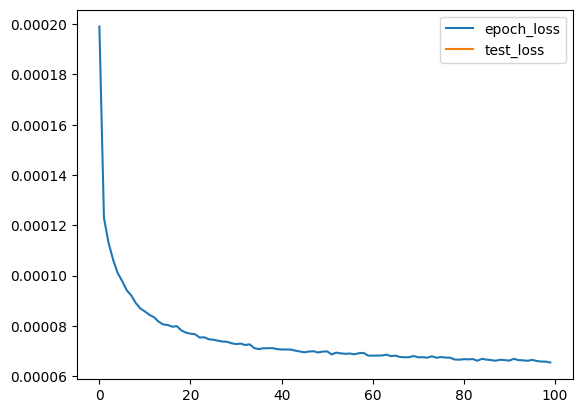

In [21]:
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    
    ## Batchwise Training
    for X_batch, y_batch in tqdm(train_loader):
        X_batch = X_batch.to(device)
        y_batch =  y_batch.to(device).squeeze(1) # y_batch.reshape(-1, 1).to(device)
        # print(X_batch.shape, y_batch.shape)
        
        y_pred = model(X_batch)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f'{name} grad norm: {param.grad.norm().item()}')
                
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        # or
        nn.utils.clip_grad_value_(model.parameters(), clip_value=5.0)
        
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss = np.sqrt(epoch_loss/len(train_loader))
    epoch_losses.append(epoch_loss/len(train_loader))
    print('Epoch %d Loss %.4f' % (epoch, epoch_loss))
    
    # Validation every 10 epochs
    # if epoch % 10 == 0:
        # continue
    # model.eval()
    # train_rmse = 0
    # with torch.no_grad():
    #     for X_batch, y_batch in train_loader:
    #         X_batch = X_batch.to(device)
    #         y_batch =  y_batch.to(device).squeeze(1)                                                                                    
    #         y_pred = model(X_train.to(device)).detach().cpu()
    #         # y_train = y_train[:, -1, :].view(-1, 1)
    #         # print('y_pred.shape, y_train.shape', y_pred.shape, y_train.shape)
    #         train_rmse += np.sqrt(loss_fn(y_pred, y_train)).item()
    #         # y_pred = model(X_test.to(device)).detach().cpu()
    #         # y_test = y_test[:, -1, :].view(-1, 1)
    #         test_rmse = 0 #np.sqrt(loss_fn(y_pred, y_test.reshape(-1, 1)))
    # train_losses.append(train_rmse)
    # test_losses.append(test_rmse)
    # print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    
plt.plot(epoch_losses)
# plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['epoch_loss', 'test_loss'])
plt.plot()

### Inference

In [14]:

# torch.save(model.state_dict(), 'lstm.pt')

model = Model()
model.to(device)
model.load_state_dict(torch.load('lstm.pt'))
# print(model.n_features)

<All keys matched successfully>

In [15]:
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)


model.eval()
with torch.no_grad():
    test_loss = 0.0
    y_true = []
    y_preds = []
    for X_batch, y_batch in tqdm(test_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.reshape(-1, n_features)
        # print(y_batch)
        # break
        y_pred = model(X_batch)
        
        
        # print('GT %.2f Pred %.2f' %(y_batch, y_pred))
        loss = loss_fn(y_pred, y_batch)
        test_loss += loss.item()
        
        y_pred = y_pred.detach().cpu()
        y_batch = y_batch.detach().cpu()
        # print(y_pred, y_batch)
        
        y_preds.append(y_pred)
        y_true.append(y_batch)
    
    test_loss /= len(test_loader)
    print(f'Validation Loss: {test_loss:.4f}')
        
    # val_losses.append(val_loss)

100%|██████████| 9655/9655 [00:53<00:00, 179.32it/s]

Validation Loss: 0.0003


In [16]:
print(len(y_preds))

9655


In [26]:
y_preds_scaled = scaler.inverse_transform(np.array(y_preds).reshape(-1, n_features))
y_test_scaled = scaler.inverse_transform(np.array(y_true).reshape(-1, n_features))

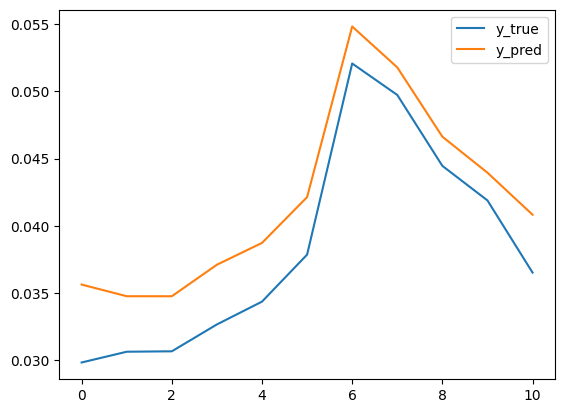

In [33]:
plt.plot(np.array(y_test[96]).reshape(-1))
plt.plot(np.array(y_preds[96]).reshape(-1))
plt.legend(['y_true', 'y_pred'])


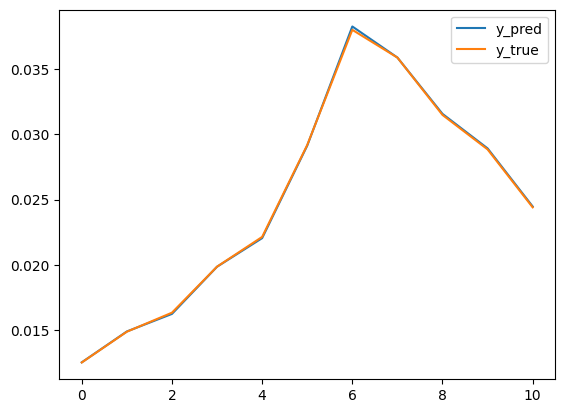

In [34]:
plt.plot(np.array(y_true[9618]).reshape(-1))
plt.plot(np.array(y_true[9617]).reshape(-1))
plt.legend(['y_pred', 'y_true'])
plt.show()

In [20]:
iv_data.Datetime.values.tolist()[int(0.7*len(iv_data)):]

['2022-10-21 10:30:00',
 '2022-10-21 10:45:00',
 '2022-10-21 11:00:00',
 '2022-10-21 11:15:00',
 '2022-10-21 11:30:00',
 '2022-10-21 11:45:00',
 '2022-10-21 12:00:00',
 '2022-10-21 12:15:00',
 '2022-10-21 12:30:00',
 '2022-10-21 12:45:00',
 '2022-10-21 13:00:00',
 '2022-10-21 13:15:00',
 '2022-10-21 13:30:00',
 '2022-10-21 13:45:00',
 '2022-10-21 14:00:00',
 '2022-10-21 14:15:00',
 '2022-10-21 14:30:00',
 '2022-10-21 14:45:00',
 '2022-10-21 15:00:00',
 '2022-10-21 15:15:00',
 '2022-10-25 09:15:00',
 '2022-10-25 09:30:00',
 '2022-10-25 09:45:00',
 '2022-10-25 10:00:00',
 '2022-10-25 10:15:00',
 '2022-10-25 10:30:00',
 '2022-10-25 10:45:00',
 '2022-10-25 11:00:00',
 '2022-10-25 11:15:00',
 '2022-10-25 11:30:00',
 '2022-10-25 11:45:00',
 '2022-10-25 12:00:00',
 '2022-10-25 12:15:00',
 '2022-10-25 12:30:00',
 '2022-10-25 12:45:00',
 '2022-10-25 13:00:00',
 '2022-10-25 13:15:00',
 '2022-10-25 13:30:00',
 '2022-10-25 13:45:00',
 '2022-10-25 14:00:00',
 '2022-10-25 14:15:00',
 '2022-10-25 14:

In [21]:
test_iv_df = pd.concat([test_dates[n_lookback:].reset_index(drop=True), pd.DataFrame(np.array(y_test).reshape(-1, n_features)).reset_index(drop=True)], axis=1)
pred_iv_df = pd.concat([test_dates[n_lookback:].reset_index(drop=True), pd.DataFrame(np.array(y_preds).reshape(-1, n_features)).reset_index(drop=True)], axis=1)

pred_iv_df  

,Datetime,Expiry,0,1,2,3,4,5,6,7,8,9,10
0,2022-10-25 12:15:00,2022-10-27 15:30:00,0.018719,0.018062,0.018461,0.021401,0.023411,0.029365,0.037986,0.034920,0.029766,0.027080,0.025631
1,2022-10-25 12:30:00,2022-10-27 15:30:00,0.017412,0.016795,0.017364,0.020409,0.022514,0.028582,0.036822,0.033690,0.028477,0.025692,0.024303
2,2022-10-25 12:45:00,2022-10-27 15:30:00,0.017696,0.016933,0.017385,0.020281,0.022261,0.028314,0.036657,0.033739,0.028758,0.026161,0.024956
3,2022-10-25 13:00:00,2022-10-27 15:30:00,0.021680,0.020549,0.020501,0.022909,0.024469,0.030098,0.039392,0.036947,0.032487,0.030502,0.029262
4,2022-10-25 13:15:00,2022-10-27 15:30:00,0.021339,0.020501,0.020563,0.023148,0.024877,0.030501,0.039639,0.036973,0.032270,0.030349,0.028768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9650,2024-05-27 14:15:00,2024-05-30 15:30:00,0.021665,0.021654,0.023679,0.027005,0.029077,0.039988,0.064575,0.060732,0.054893,0.050865,0.046957
9651,2024-05-27 14:30:00,2024-05-30 15:30:00,0.019316,0.019033,0.021001,0.024240,0.026224,0.037613,0.062336,0.058700,0.053068,0.048772,0.045323
9652,2024-05-27 14:45:00,2024-05-30 15:30:00,0.018136,0.017640,0.019472,0.022610,0.024463,0.036248,0.061341,0.057879,0.052384,0.047851,0.044860
9653,2024-05-27 15:00:00,2024-05-30 15:30:00,0.018645,0.018012,0.019613,0.022617,0.024314,0.036138,0.061533,0.058225,0.052839,0.048289,0.045562


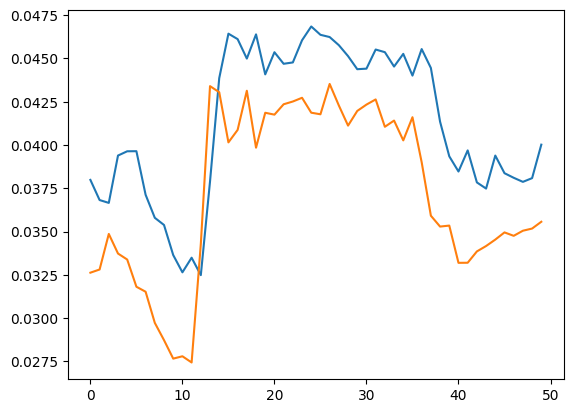

In [40]:
pred_iv_df.iloc[:, 8][:50].plot()
# plt.show()
test_iv_df.iloc[:, 8][:50].plot()
# plt.legend(['y_pred', 'y_true'])
plt.show()

In [ ]:
scaler.inverse_transform(np.array(y_test).reshape(-1, n_features))

In [28]:
test_iv_df['Expiry'].unique()

array(['2022-10-27 15:30:00', '2022-11-03 15:30:00',
       '2022-11-10 15:30:00', '2022-11-17 15:30:00',
       '2022-11-24 15:30:00', '2022-12-01 15:30:00',
       '2022-12-08 15:30:00', '2022-12-15 15:30:00',
       '2022-12-22 15:30:00', '2022-12-29 15:30:00',
       '2023-01-05 15:30:00', '2023-01-12 15:30:00',
       '2023-01-19 15:30:00', '2023-01-25 15:30:00',
       '2023-02-02 15:30:00', '2023-02-09 15:30:00',
       '2023-02-16 15:30:00', '2023-02-23 15:30:00',
       '2023-03-02 15:30:00', '2023-03-09 15:30:00',
       '2023-03-16 15:30:00', '2023-03-23 15:30:00',
       '2023-03-29 15:30:00', '2023-04-06 15:30:00',
       '2023-04-13 15:30:00', '2023-04-20 15:30:00',
       '2023-04-27 15:30:00', '2023-05-04 15:30:00',
       '2023-05-11 15:30:00', '2023-05-18 15:30:00',
       '2023-05-25 15:30:00', '2023-06-01 15:30:00',
       '2023-06-08 15:30:00', '2023-06-15 15:30:00',
       '2023-06-22 15:30:00', '2023-06-29 15:30:00',
       '2023-06-28 15:30:00', '2023-07-06 15:3

In [29]:
expiry = '2023-09-28 15:30:00'
test_iv_df_exp_1 =test_iv_df[test_iv_df['Expiry'] == expiry]
pred_iv_df_exp_1 =pred_iv_df[pred_iv_df['Expiry'] == expiry]

In [38]:
print(pred_iv_df_exp_1.iloc[:, 10].values)
print(test_iv_df_exp_1.iloc[:, 10].values)


[0.14699346 0.0258635  0.020542   0.01757122 0.01685655 0.01528841
 0.01429662 0.0144564  0.01325586 0.01269434 0.01190806 0.01200398
 0.01224083 0.00953258 0.00943897 0.00910475 0.0093452  0.00985211
 0.00901646 0.01005343 0.01010298 0.01025648 0.00918785 0.0094518
 0.01060659 0.01138196 0.02504007 0.02604515 0.02464849 0.02372342
 0.02453588 0.02436171 0.0247798  0.024715   0.02443304 0.02405684
 0.02401561 0.02383059 0.02214213 0.02361906 0.02341333 0.02262531
 0.02139118 0.02016591 0.01964805 0.01889932 0.01849092 0.01860255
 0.01748437 0.0193329  0.02011878 0.02496297 0.02656016 0.02520614
 0.02487892 0.02380048 0.02306085 0.02296501 0.0232887  0.02200011
 0.02191881 0.02143279 0.02200407 0.0217414  0.02156986 0.02328062
 0.02395765 0.02234865 0.0219643  0.02232104 0.02156907 0.02192276
 0.02070773 0.02026755 0.02022906 0.02033135 0.03071462 0.03295995
 0.03422851 0.03219532 0.03481459 0.03418325 0.03239019 0.03000109
 0.02961528 0.02916532 0.03068129 0.02965862 0.02789684 0.02947

In [74]:
((test_iv_df_exp_1.iloc[:, 9] - pred_iv_df_exp_1.iloc[:, 9])[1:-50]).mean()

-0.0034751163

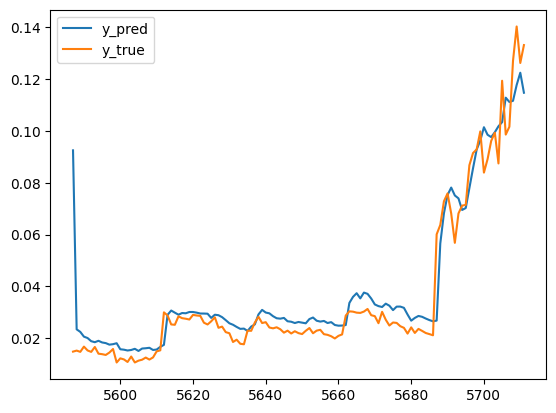

In [39]:
pred_iv_df_exp_1.iloc[:, 9].plot()
# plt.show()
test_iv_df_exp_1.iloc[:, 9].plot()
plt.legend(['y_pred', 'y_true'])
plt.show()

In [55]:
# print(test_iv_df_exp_1.head(), pred_iv_df_exp_1.head())

In [116]:
test_iv_df_exp_1.iloc[124, 2:]

0     0.263786
1     0.221968
2     0.158564
3     0.084729
4      0.03223
5     0.028044
6     0.143922
7     0.232746
8     0.325854
9     0.384829
10    0.441905
Name: 962, dtype: object

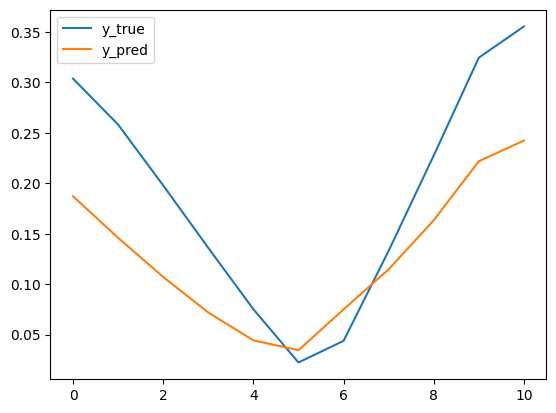

In [63]:
test_iv_df_exp_1.iloc[-1, 2:].plot()
pred_iv_df_exp_1.iloc[-1, 2:].plot()
plt.legend(['y_true', 'y_pred'])



<Axes: >

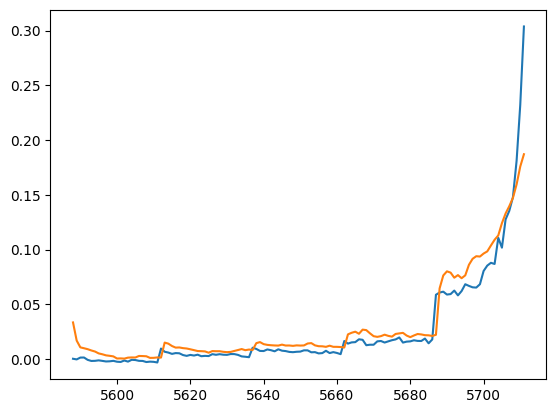

In [43]:
test_iv_df_exp_1.iloc[, 2:].iloc[:,0].plot()
pred_iv_df_exp_1.iloc[1:, 2:].iloc[:,0].plot()

<Axes: >

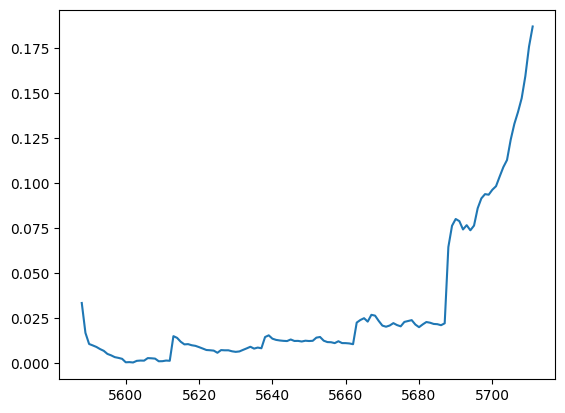

In [66]:
pred_iv_df_exp_1.iloc[1:, 2:].iloc[:,0].plot()

In [65]:
test_iv_df_exp_1.iloc[-1, 2:]

0      0.30371
1     0.258167
2     0.197846
3      0.13596
4     0.075135
5     0.022376
6     0.043826
7     0.133064
8     0.227575
9      0.32453
10    0.355407
Name: 5711, dtype: object

In [66]:
test_iv_df_exp_1.iloc[1:, 2:].values

array([[ 4.10165638e-04,  2.36232579e-03,  3.79247963e-03, ...,
         1.08043104e-02,  8.65255669e-03,  6.99040294e-03],
       [-1.82289630e-04,  1.80616230e-03,  3.27029824e-03, ...,
         1.04458593e-02,  8.27498361e-03,  6.69507310e-03],
       [ 1.48940831e-03,  3.75388190e-03,  5.11956587e-03, ...,
         1.21566355e-02,  9.76619869e-03,  8.03251565e-03],
       ...,
       [ 1.81101829e-01,  1.43655911e-01,  1.06100366e-01, ...,
         1.96938038e-01,  2.47757316e-01,  2.71692604e-01],
       [ 2.32260555e-01,  1.96005270e-01,  1.52570337e-01, ...,
         1.96775764e-01,  2.62695044e-01,  2.83524990e-01],
       [ 3.03710371e-01,  2.58166760e-01,  1.97845504e-01, ...,
         2.27575451e-01,  3.24530184e-01,  3.55407208e-01]], dtype=float32)

In [45]:
expiration_dates = test_iv_df_exp_1['Datetime'] #list(volatility_surface_dict.keys())
# print(expiration_dates)
strikes = [i for i in range(11)] #all_strikes[3:17] #[strike for strike in volatility_surface_dict[strikes[0]].keys()]
# print(strikes)

# Create the 3D plot
fig_test = go.Figure(data=[go.Surface(
    x=expiration_dates,
    y=strikes,
    z=test_iv_df_exp_1.iloc[1:, 2:].values)
])



# Set the plot title and axis labels
fig_test.update_layout(
    title='Implied Volatility Surface',
    scene=dict(
        xaxis_title='Expiration Date',
        yaxis_title='Strike Price',
        zaxis_title='Implied Volatility'
    )
)

# Show the plot
fig_test.show()

In [46]:
expiration_dates = pred_iv_df_exp_1['Datetime'] #list(volatility_surface_dict.keys())
# print(expiration_dates)
strikes = [i for i in range(11)] #all_strikes[3:17] #[strike for strike in volatility_surface_dict[strikes[0]].keys()]
# print(strikes)

# Create the 3D plot
fig_pred = go.Figure(data=[go.Surface(
    x=expiration_dates,
    y=strikes,
    z=pred_iv_df_exp_1.iloc[1:, 2:].values)
])

# Set the plot title and axis labels
fig_pred.update_layout(
    title='Implied Volatility Surface',
    scene=dict(
        xaxis_title='Expiration Date',
        yaxis_title='Strike Price',
        zaxis_title='Implied Volatility'
    )
)

# Show the plot
fig_pred.show()

In [102]:
test_iv_df_exp_1.iloc[50][2:].values

array([0.016586188, 0.01695827, 0.017109212, 0.019424042, 0.020882301,
       0.029124647, 0.0385373, 0.037563726, 0.03467245, 0.033814203,
       0.030621734], dtype=object)

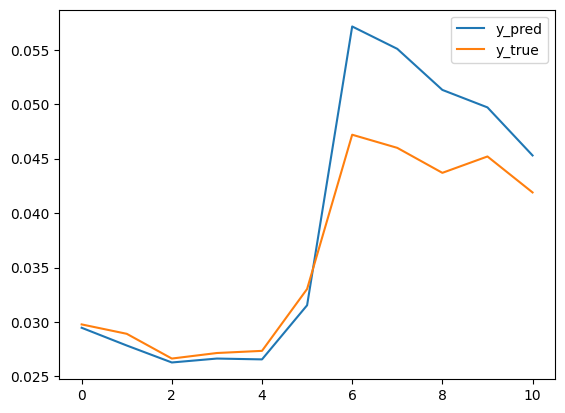

In [104]:
plt.plot(test_iv_df_exp_1.iloc[80][2:].values)
plt.plot(pred_iv_df_exp_1.iloc[80][2:].values)
plt.legend(['y_pred', 'y_true'])
plt.show()

In [44]:
test_dates[n_lookback:]

,Datetime,Expiry
22632,2022-10-25 12:15:00,2022-10-27 15:30:00
22633,2022-10-25 12:30:00,2022-10-27 15:30:00
22634,2022-10-25 12:45:00,2022-10-27 15:30:00
22635,2022-10-25 13:00:00,2022-10-27 15:30:00
22636,2022-10-25 13:15:00,2022-10-27 15:30:00
...,...,...
32282,2024-05-27 14:15:00,2024-05-30 15:30:00
32283,2024-05-27 14:30:00,2024-05-30 15:30:00
32284,2024-05-27 14:45:00,2024-05-30 15:30:00
32285,2024-05-27 15:00:00,2024-05-30 15:30:00


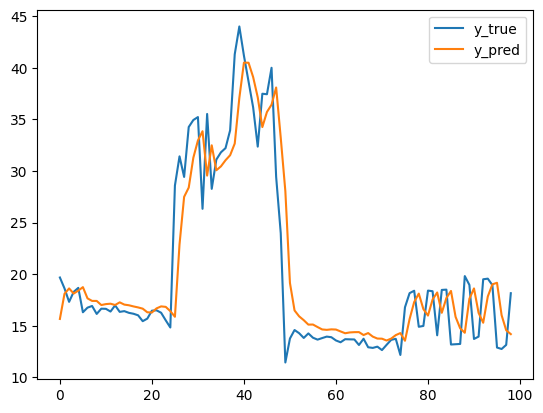

In [45]:
plt.plot(scaler.inverse_transform(np.array(y_true).reshape(-1, n_features))[-100:-1], label='y_true')
plt.plot(scaler.inverse_transform(np.array(y_preds).reshape(-1, n_features))[-100:-1], label='y_pred')
plt.legend()
plt.show()

In [44]:
np.concatenate((scaler.inverse_transform(np.array(y_true).reshape(-1, 1))[-100:], scaler.inverse_transform(np.array(y_preds).reshape(-1, 1))[-100:]), axis=1)

array([[19.68446508, 15.67074951],
       [18.63089864, 18.10550717],
       [17.32664297, 18.62703471],
       [18.29509303, 18.13021098],
       [18.68000148, 18.41071687],
       [16.31726251, 18.75271098],
       [16.76449578, 17.66387917],
       [16.9257123 , 17.41628778],
       [16.15651688, 17.41454166],
       [16.6643408 , 17.01703033],
       [16.65046986, 17.10838301],
       [16.38707496, 17.14650599],
       [16.98574243, 17.02134961],
       [16.35618983, 17.2778413 ],
       [16.42672534, 17.06024943],
       [16.26147399, 16.99559168],
       [16.17206104, 16.88274059],
       [16.02219727, 16.7868296 ],
       [15.45365243, 16.66709921],
       [15.70188562, 16.31619285],
       [16.47000301, 16.29301048],
       [16.50695355, 16.69179106],
       [16.2711356 , 16.88646708],
       [15.53747446, 16.83968881],
       [14.84159089, 16.42819538],
       [28.59322564, 15.88121946],
       [31.42183866, 22.88911374],
       [29.42894325, 27.49736872],
       [34.26067503,

In [14]:
y_test_list = y_test.squeeze(-1).squeeze(-1).tolist()
y_pred_list = model(X_test.to(device)).detach().cpu().squeeze(-1).tolist()
print(min(y_test_list), max(y_test_list))
print(min(y_pred_list), max(y_pred_list))

-0.004807950928807259 0.2474205493927002
0.006857529282569885 0.1649029552936554


In [15]:
mean_squared_error(scaler.inverse_transform(np.array(y_test_list).reshape(-1, 1)), scaler.inverse_transform(np.array(y_pred_list).reshape(-1,1)))

7.210786477263129

10625 10625


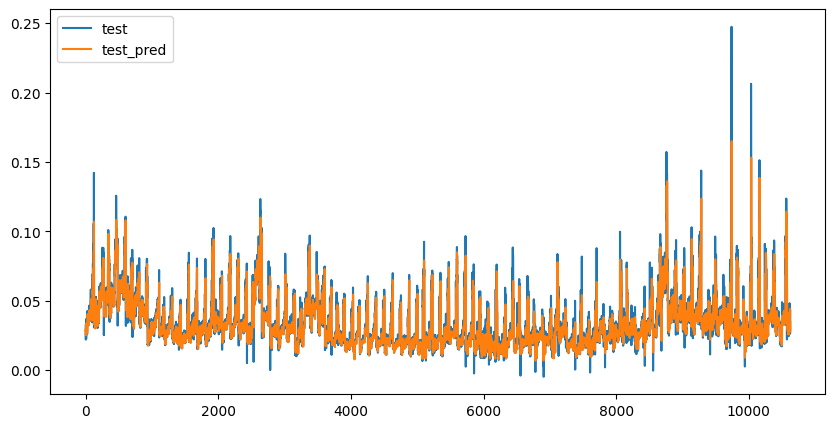

In [16]:
test_plot = y_test.squeeze(-1).squeeze(-1).tolist()
test_pred_plot = model(X_test.to(device)).detach().cpu().squeeze(-1)

print(len(test_plot), len(test_pred_plot))


plt.figure(figsize=(10, 5))
plt.plot(test_plot[:])
plt.plot(test_pred_plot[:])
plt.legend(['test', 'test_pred'])
plt.show()

In [ ]:
plt.plot(model(X_test.to(device)).detach().cpu().squeeze(-1))

In [ ]:

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(data) * np.nan
    print(len(train_plot))
    y_pred = model(X_train.to(device)).detach().cpu()
    # y_pred = y_pred[:, -1, :]
    train_plot[n_lookback:train_size] = model(X_train.to(device)).detach().cpu() #[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(data) * np.nan
    test_plot[train_size+n_lookback:len(data)] = model(X_test.to(device)).detach().cpu() #[:, -1, :]
# plot
# plt.plot(scaler.transform(data), c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

### LSTM (vector Input)

In [ ]:
import torch
import torch.nn as nn

class AttLSTM(nn.Module):
    def __init__(self):
        super(AttLSTM, self).__init__()
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=135, num_layers=1, batch_first=True)
        
        # Attention layer
        self.attention = nn.Linear(135, 1)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(input_size=135, hidden_size=135, num_layers=1, batch_first=True)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        
        # Fully connected layer
        self.fc = nn.Linear(135, 45)
    
    def forward(self, x):
        # x shape: (batch_size, 3, 45)
        
        # First LSTM layer
        lstm1_out, _ = self.lstm1(x)
        # lstm1_out shape: (batch_size, 3, 135)
        
        lstm1_out = self.dropout1(lstm1_out)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm1_out), dim=1)
        attended_out = lstm1_out * attention_weights
        
        # Second LSTM layer
        lstm2_out, _ = self.lstm2(attended_out)
        # We only want the last time step output
        lstm2_out = lstm2_out[:, -1, :]
        # lstm2_out shape: (batch_size, 135)
        
        lstm2_out = self.dropout2(lstm2_out)
        
        # Fully connected layer
        out = self.fc(lstm2_out)
        # out shape: (batch_size, 45)
        
        return out

# Instantiate the model
model = AttLSTM()

# Example usage:
batch_size = 50
x = torch.randn(batch_size, 3, 45)  # (batch_size, time_steps, features)
output = model(x)
print(output.shape)  # Should be (batch_size, 45)

In [ ]:

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(data) * np.nan
    y_pred = model(X_train.to(device))
    print(y_pred.shape)
    # y_pred = y_pred[:, -1, :]
    train_plot[n_lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(data) * np.nan
    test_plot[train_size+n_lookback:len(data)] = model(X_test)[:, -1, :]
# plot
plt.plot(data, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()